# Chapter 17
## FFT Convolution

---



In [22]:
# Do I use all these? No idea, I just copied it from the last notebook
from math import sin, cos, pi, exp
import matplotlib.pyplot
# jupyter nbextension enable --py widgetsnbextension
from ipywidgets import interact, interactive, fixed, interact_manual
from numpy.fft import rfft, irfft
from numpy import absolute, arange, append, convolve, array_split
import numpy
import random

---

# Overlap-add Method

Signals can be very very long
* Can't process all in one big chunk

Overlap-add
0. Decompose Signal
0. Process each decomposed signal component
0. Recombine processesd signal components

---

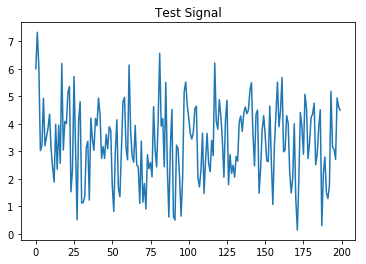

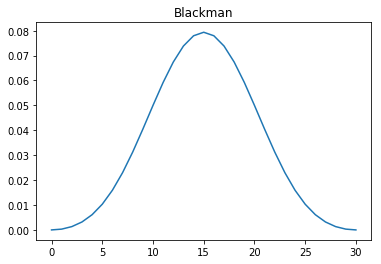

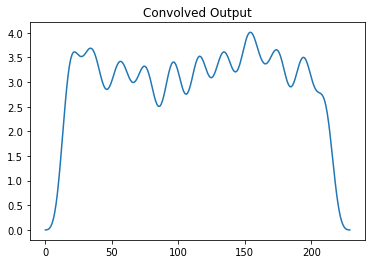

Original signal length: 200
Blackman signal length: 31
Convolved signal length: 230, N+M-1


In [23]:
"""
A blackman window we'll play with
"""
def blackman(M):
    h = []
    for i in range(0,M+1):
        blackman = 0.42 - 0.5*cos(2*pi*i/M) + 0.08*cos(4*pi*i/M)
        h.append(blackman)

    # normalize
    h = [val / sum(h) for val in h]
    return h

"""
Some signal we'll use to play with
"""
def some_signal():
    h = []
    M = 50
    random.seed(12)
    for i in arange(0,M,.25):
        a = sin(2*pi*i)
        b = exp(2*pi*1/(i+5))
        c = 2*pi*i/400
        d = cos(2*pi/5*i)
        e = random.random()*pi
        h.append(a+b+c+d+e)
    return h

"""
Plot and show data
"""
def plot_and_show(data, title=""):
    matplotlib.pyplot.title(title)
    matplotlib.pyplot.plot(data)
    matplotlib.pyplot.show()
    
# Remove inline to get a sick ol' drag and droppable window
%matplotlib inline
plot_and_show(some_signal(), "Test Signal")
plot_and_show(blackman(30), "Blackman")
plot_and_show(convolve(blackman(30), some_signal()), "Convolved Output")
# Look at all the recomputations!! AH WHAT AM I DOING WITH MY LIFE?
print(f"Original signal length: {len(some_signal())}")
print(f"Blackman signal length: {len(blackman(30))}")
print(f"Convolved signal length: {len(convolve(blackman(30), some_signal()))}, N+M-1")

## Using overlap add (although this signal is short)

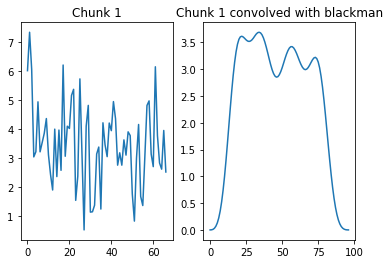

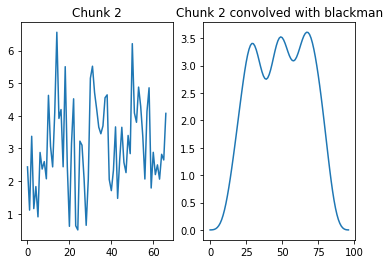

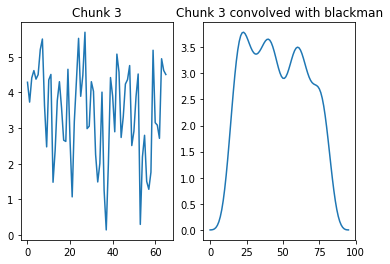

In [24]:
"""
Plot 2 pairs of data
"""
def plot_pairs(a,b,atitle="", btitle=""):
    f,ax = matplotlib.pyplot.subplots(1,2)
    ax[0].set_title(atitle)
    ax[0].plot(a)
    ax[1].set_title(btitle)
    ax[1].plot(b)

"""
Split siggy into 3 chunks
"""
chunks = array_split(some_signal(), 3)

"""
Plot our fine chunks, and convolved chunks
"""
out_chunks = []
for i,chunk in enumerate(chunks):
    out_chunks.append(convolve(blackman(30), chunk))
    plot_pairs(chunk, out_chunks[i], f"Chunk {i+1}", f"Chunk {i+1} convolved with blackman")
    
# darn numpy arrays
out_chunks = [list(chunk) for chunk in out_chunks]

In [25]:
print(f"Original signal length: {len(some_signal())}")
print(f"Blackman signal length: {len(blackman(30))}")
print(f"Convolved signal length: {len(convolve(blackman(30), some_signal()))}, N+M-1")

Original signal length: 200
Blackman signal length: 31
Convolved signal length: 230, N+M-1


In [26]:
for i,x in enumerate(out_chunks):
    print(f"Chunk length {i+1} is {len(x)}")
print(f"Total size of all output chunks: {sum(len(chunk) for chunk in out_chunks)}")

Chunk length 1 is 97
Chunk length 2 is 97
Chunk length 3 is 96
Total size of all output chunks: 290


---

## How do we combine the extra chunks?
* Add the last N samples from chunk i0 and the first N samples from chunk i1, etc, where N is size of the filter kernel
  * This is where the signals "overlap", so we combine it there
  
---

In [27]:
overlap_length = len(blackman(30)) - 1

# I have no idea what the book does for this or if it provides code
output_signal = out_chunks[0]
for i in range(1,len(out_chunks)):
    # Store overlapping chunks for adding
    overlap1 = output_signal[-overlap_length:]
    overlap2 = out_chunks[i][:overlap_length]
    # Remove overlapping chunks
    output_signal = output_signal[:-overlap_length]
    out_chunks[i] = out_chunks[i][overlap_length:]
    # Add overlaps
    overlap_sum = [o1+o2 for o1,o2 in zip(overlap1, overlap2)]
    output_signal = output_signal + overlap_sum + out_chunks[i]

print(f"The overlap-added output signal length is {len(output_signal)}")

The overlap-added output signal length is 230


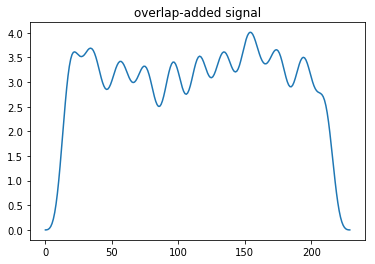

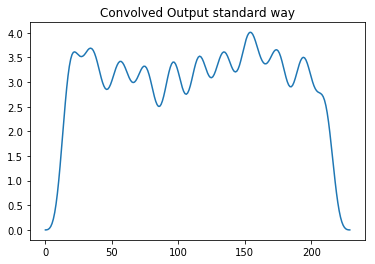

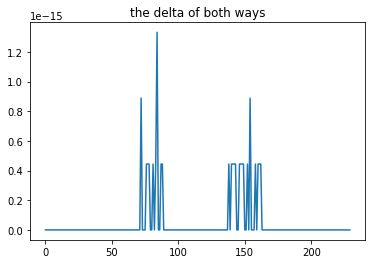

In [28]:
plot_and_show(output_signal, "overlap-added signal")
standard_way = convolve(blackman(30), some_signal())
plot_and_show(standard_way, "Convolved Output standard way")
delta = [abs(o-s) for o,s in zip(output_signal, standard_way)]
# DOUBLE PRECISION FLOATING ERRORS! (not like actual differences)
plot_and_show(delta, "the delta of both ways")

* Negligible difference between methods (double precision limits)
* Where are the differences above located in the delta plot?
  * Where the overlaps were added

---

# FFT Convolution + Overlap-Add
0. FFT Filter Kernel
0. FFT Input Segment
0. Filter Kernel multipled by Input Segment in frequency domain
0. Inverse FFT of multiplication to get output segment
0. Combine output segments
---

* Same as overlap-add method above
  * Just insert an FFT and do multiplication instead of convolution in above example
* Remember to not fall victim to circular convolution
  * Make sure input segments are zero padded if needed
  * Convolution yields N+M-1 length time domain outputs
  * A 64 point input signal and a 65 point filter kernel needs a 128 point FFT
---

## FFT Convolution is faster for large inputs
<img src="dft-vs-fft-from-the-book.png">
Above is from the book